In [1]:
!git clone https://github.com/ayanokojix21/NeuroFormer2.0.git

Cloning into 'NeuroFormer2.0'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 52 (delta 16), reused 44 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 4.91 MiB | 11.25 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [2]:
%cd NeuroFormer2.0

/content/NeuroFormer2.0


In [3]:
# Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import matplotlib.pyplot as plt
import json

In [4]:
from model.neuroformer import NeuroFormer
from data.dataloader import load_data
from tokenizers import Tokenizer

In [5]:
# Setting Device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
# For Reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [7]:
# Loading Custom trained tokenizer
tokenizer = Tokenizer.from_file("tokenizer/bpe_tokenizer.json")
vocab_size = tokenizer.get_vocab_size()
print(f"Loaded tokenizer with vocab size: {vocab_size}")

Loaded tokenizer with vocab size: 2000


In [8]:
# Getting Special Token Ids
special_tokens = {
    'pad_id': tokenizer.token_to_id("<pad>"),
    'unk_id': tokenizer.token_to_id("<unk>"),
    'bos_id': tokenizer.token_to_id("<bos>"),
    'eos_id': tokenizer.token_to_id("<eos>"),
    'user_id': tokenizer.token_to_id("<user>"),
    'assistant_id': tokenizer.token_to_id("<assistant>")
}
print(f"Special tokens: {special_tokens}")

Special tokens: {'pad_id': 1994, 'unk_id': 1995, 'bos_id': 1996, 'eos_id': 1997, 'user_id': 1998, 'assistant_id': 1999}


In [15]:
# Model HyperParameters
vocab_size = vocab_size
sequence_length = 512
d_model = 512
num_heads = 8
hidden = 4 * d_model
num_layers = 6
drop_prob = 0.2

In [16]:
# Training HyperParameters
batch_size = 32
total_steps = 4000
lr = 3e-4
weight_decay = 0.01
max_grad_norm = 1.0
eval_interval = 200
best_model_path = 'model/best_model.pt'
os.makedirs('model', exist_ok=True)

In [17]:
train_path = 'data/shakespeare_train.txt'
valid_path = 'data/shakespeare_val.txt'

with open(train_path, 'r', encoding='utf-8') as f:
    train_text = f.read()

with open(valid_path, 'r', encoding='utf-8') as f:
    valid_text = f.read()

In [18]:
train_loader = load_data(
    text=train_text,
    tokenizer=tokenizer,
    batch_size=batch_size,
    max_length=sequence_length,
    stride=sequence_length // 16,
    shuffle=True,
    drop_last=True
)

valid_loader = load_data(
    text=valid_text,
    tokenizer=tokenizer,
    batch_size=batch_size,
    max_length=sequence_length,
    stride=sequence_length // 16,
    shuffle=False,
    drop_last=False
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(valid_loader)}")

Training batches: 1449
Validation batches: 164


In [19]:
model = NeuroFormer(
    vocab_size=vocab_size,
    sequence_length=sequence_length,
    d_model=d_model,
    num_heads=num_heads,
    hidden=hidden,
    num_layers=num_layers,
    drop_prob=drop_prob
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 20,201,472


In [20]:
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(ignore_index=special_tokens['pad_id'])

lr_scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=3e-4,
    min_lr=1e-6,
)

In [21]:
def evaluate_model():
    """Evaluate model on validation set"""

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for input_ids, target_ids in valid_loader:
            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)

            logits = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))

            total_loss += loss.item()

    avg_loss = total_loss / len(valid_loader)

    return avg_loss

In [22]:
def train_model():
    """Main training loop"""

    model.train()
    best_val_loss = float('inf')
    step = 0

    train_losses, val_losses, val_steps = [], [], []

    while step < total_steps:
        for input_ids, target_ids in train_loader:
            if step >= total_steps:
                break

            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)

            optimizer.zero_grad()
            logits = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

            train_losses.append(loss.item())

            if step % eval_interval == 0 or step == total_steps-1:
                val_loss = evaluate_model()
                val_losses.append(val_loss)
                val_steps.append(step)

                model.train()

                print(f"Step {step:4d} | Val Loss: {val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

                lr_scheduler.step(val_loss)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), best_model_path)
                    print(f"Best model saved Val Loss: {val_loss:.4f}")

            step += 1

    return train_losses, val_losses, val_steps

In [23]:
def visualize(train_losses, val_losses, val_steps):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_steps, val_losses, label='Val Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [30]:
def test_generation():
    """Test text generation after training"""

    model.eval()

    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))

    test_prompts = [
        "To be or not to be",
        "Romeo and Juliet",
        "The quick brown fox"
    ]

    for prompt in test_prompts:

        full_prompt = f"<bos>{prompt}"
        encoded = tokenizer.encode(full_prompt)
        input_ids = torch.tensor([encoded.ids], dtype=torch.long).to(device)

        with torch.no_grad():
            generated = model.generate(
                input_ids=input_ids,
                max_length=500,
                temperature=1.3,
                top_k=100,
                top_p=0.9,
                eos_token_id=special_tokens['eos_id']
            )

        generated_text = tokenizer.decode(generated[0].cpu().tolist())
        print(f"Prompt: '{prompt}'")
        print(f"Generated: '{generated_text}'\n")

In [25]:
train_losses, val_losses, val_steps = train_model()

Step    0 | Val Loss: 7.3463 | LR: 0.000300
Best model saved Val Loss: 7.3463
Step  300 | Val Loss: 4.7625 | LR: 0.000300
Best model saved Val Loss: 4.7625
Step  600 | Val Loss: 4.5448 | LR: 0.000300
Best model saved Val Loss: 4.5448
Step  900 | Val Loss: 4.3951 | LR: 0.000300
Best model saved Val Loss: 4.3951
Step 1200 | Val Loss: 4.2445 | LR: 0.000300
Best model saved Val Loss: 4.2445
Step 1500 | Val Loss: 4.1191 | LR: 0.000300
Best model saved Val Loss: 4.1191
Step 1800 | Val Loss: 4.0323 | LR: 0.000300
Best model saved Val Loss: 4.0323
Step 2100 | Val Loss: 3.9652 | LR: 0.000300
Best model saved Val Loss: 3.9652
Step 2400 | Val Loss: 3.9356 | LR: 0.000300
Best model saved Val Loss: 3.9356
Step 2700 | Val Loss: 3.9067 | LR: 0.000300
Best model saved Val Loss: 3.9067
Step 2999 | Val Loss: 3.9044 | LR: 0.000300
Best model saved Val Loss: 3.9044


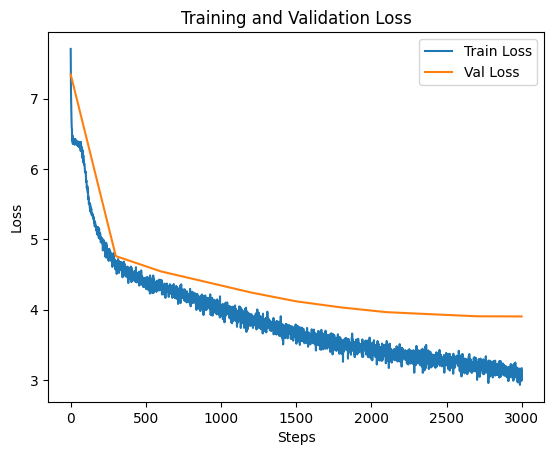

In [26]:
visualize(train_losses, val_losses, val_steps)

In [31]:
test_generation()

Prompt: 'To be or not to be'
Generated: 'To be or not to be fearful. LADYSANDER. Not so in mine own fault, but to do as my sorrow too! BEROWNE. How sayingale, why sin a dozen fantast; I am thyself angaming knight, and therefore can I love no farther; the better for my duke. BEROWNE. If these can carry with a bond; and with another dukin, I tell you my knee. Had he not that tongue that maintain a man as He is to scorn to a man. I will be reveng'd ere now, I hope mine own hands be honest; and therefore tell you my gain. CLARENCE. No; I look my sadness grows stronger than a coward; For what dealks have merites, can say: A plague of saints are in me, and their praise defence. Better in vain is better judg'd than they; and for their fear have not in the grace of them. Stay, Hall, gentle South, you are too feasters true; your father's peace, not a memory any reason Which in the world he hath done their oath, Which to make the streets; here's the commons of war There's measure, we hold our ca